In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bering = pd.read_excel(filepath, sheet_name='Bering-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Bering)
fp.date_time(Bering)

,Extent,Date
0,320266.650,1979-01-01
1,541778.338,1979-02-01
2,638262.988,1979-03-01
3,423025.159,1979-04-01
4,215587.216,1979-05-01
...,...,...
488,317377.493,2023-05-01
489,39601.476,2023-06-01
490,16935.702,2023-07-01
491,1305.744,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bering['Extent'] = scaler.fit_transform(Bering['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bering['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((473, 12, 1), (473,))

In [8]:
X_train, y_train = X[:384], y[:384]
X_val, y_val = X[384:432], y[384:432]
X_test, y_test = X[432:], y[432:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bering_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
48/48 [==============================] - 20s 280ms/step - loss: 0.1674 - root_mean_squared_error: 0.4092 - val_loss: 0.0506 - val_root_mean_squared_error: 0.2250
Epoch 2/50
48/48 [==============================] - 9s 201ms/step - loss: 0.1236 - root_mean_squared_error: 0.3516 - val_loss: 0.0411 - val_root_mean_squared_error: 0.2026
Epoch 3/50
48/48 [==============================] - 1s 16ms/step - loss: 0.0974 - root_mean_squared_error: 0.3121 - val_loss: 0.0464 - val_root_mean_squared_error: 0.2155
Epoch 4/50
48/48 [==============================] - 1s 14ms/step - loss: 0.0907 - root_mean_squared_error: 0.3011 - val_loss: 0.0478 - val_root_mean_squared_error: 0.2187
Epoch 5/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0855 - root_mean_squared_error: 0.2925 - val_loss: 0.0490 - val_root_mean_squared_error: 0.2214
Epoch 6/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0787 - root_mean_squared_error: 0.2805 - val_loss: 0.0493 - val_roo

Epoch 47/50
48/48 [==============================] - 1s 18ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.1139 - val_root_mean_squared_error: 0.3375
Epoch 48/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_loss: 0.1044 - val_root_mean_squared_error: 0.3232
Epoch 49/50
48/48 [==============================] - 1s 18ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3590
Epoch 50/50
48/48 [==============================] - 1s 18ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077 - val_loss: 0.0936 - val_root_mean_squared_error: 0.3059


In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

1.1711326917012532 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

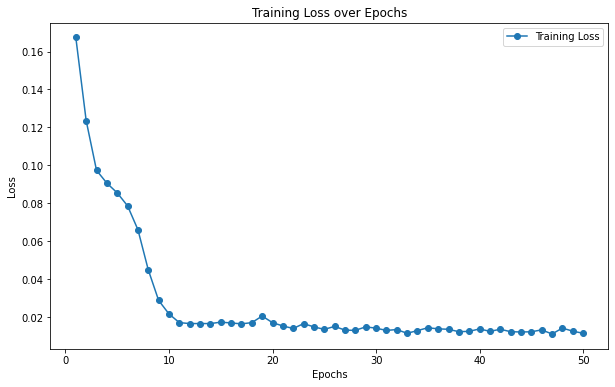

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

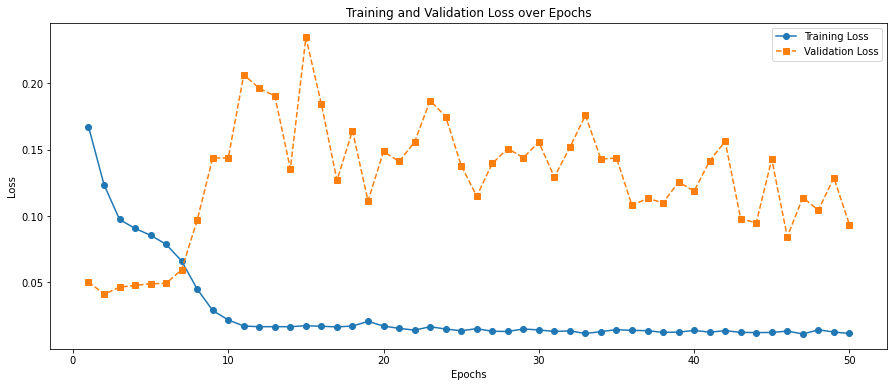

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bering_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 0s/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.27345119736332674
MAE : 0.24237125170143292


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,182039.765625,708542.184
1,184238.796875,652598.000
2,190487.250000,414216.785
3,196990.156250,236263.303
4,203541.000000,43422.368
5,209575.687500,2161.744
6,214670.937500,944.181
7,219553.984375,13977.643
8,216859.281250,24795.001
9,200560.390625,168828.990


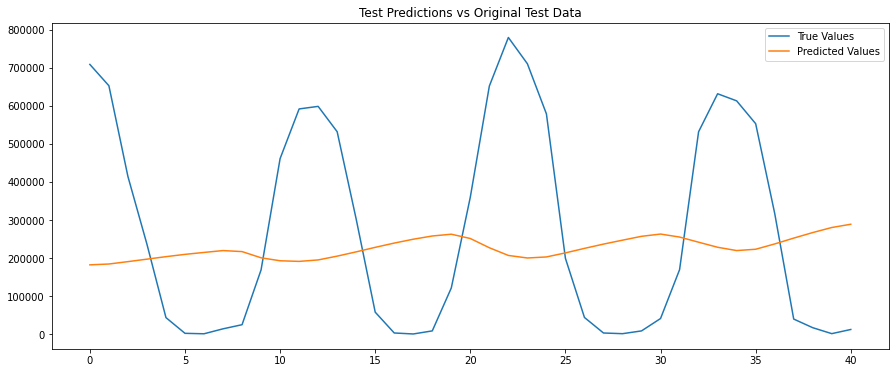

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

15/15 [==============================] - 0s 10ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

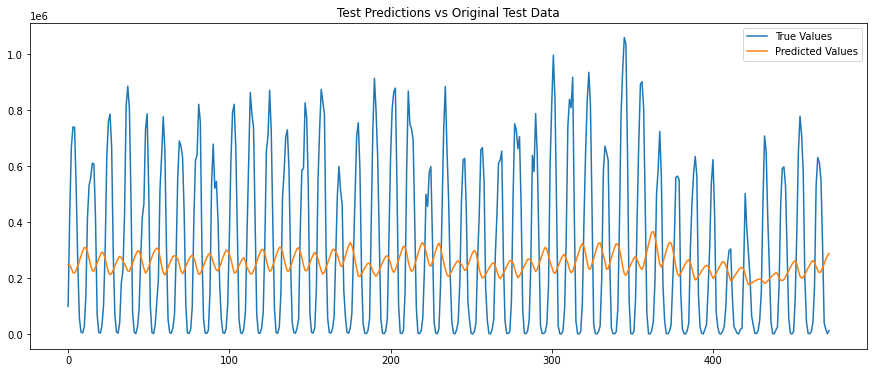

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()